In [1]:
# !pip install catboost
# !pip install scikit-optimize

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)

%matplotlib inline

In [3]:
def read_file(url):
  url = url + "?raw=true"
  df = pd.read_csv(url)
  return df

url = "https://github.com/andbren/TDT-4173/blob/main/dataset/apartments_train.csv"
apartments = read_file(url)

url = "https://github.com/andbren/TDT-4173/blob/main/dataset/buildings_train.csv"
buildings = read_file(url)

print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data.set_index("id", inplace=True)

All apartments have an associated building: True


In [4]:
url = "https://github.com/andbren/TDT-4173/blob/main/dataset/apartments_test.csv"
apartments_test = read_file(url)

url = "https://github.com/andbren/TDT-4173/blob/main/dataset/buildings_test.csv"
buildings_test = read_file(url)

print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
data_test.set_index("id", inplace=True)

All apartments have an associated building: True


In [5]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

def evaluate_predictions(predictions: pd.DataFrame, y_true: pd.DataFrame):
    """Evaluate predictions, the same way as done when uploading to Kaggle.

    Args:
      predictions: pandas DataFrame with predictions. Should be in the same
        order as the True data.
    
    Example:
      >>> # model = a previously trained model
      >>> results = model.predict(X_valid)
      >>> score = evaluate_predictions(results, y_valid)
    """
    return root_mean_squared_log_error(y_true, predictions)

In [6]:
# Add price bins, to sort and later split data
NUM_BUCKETS = 10
log_price = np.log10(data['price'])

price_bin_max = log_price.max()
price_bin_min = log_price.min()
price_bin_size = (price_bin_max - price_bin_min) / NUM_BUCKETS

price_bins = [
    i*price_bin_size + price_bin_min for i in range(NUM_BUCKETS)
]
labels = [i for i in range(len(price_bins) - 1)]

data['price_bin'] = pd.cut(log_price, bins=price_bins, labels=labels)
data["price_bin"].fillna(8, inplace=True)


# Preprocessing

In [7]:
# Fill in missing values
default_values = {   
    "seller": 4,          # Add a new category to seller - UNKNOWN = 4
    "area_kitchen": np.median(data["area_kitchen"].dropna()),
    "area_living": np.median(data["area_living"].dropna()),
    "layout": 3,          # Add a new category to layout - UNKNOWN = 3
    "ceiling": np.median(data["ceiling"].dropna()),
    "bathrooms_shared": 0,
    "bathrooms_private": 0,
    "windows_court": 2,   # Change "windows_court" to categorical. New category - UNKNOWN = 2
    "windows_street": 2,  # Change "windows_street" to categorical. New category - UNKNOWN = 2
    "balconies": 0,
    "loggias": 0,
    "condition": 4,       # Add a new category to condition - UNKNOWN = 4
    "phones": 0,
    "new": 2,             # Change "new" to be categorical. New category - UNKNOWN = 2
    "district": 12,       # Add new category to district - UNKNOWN = 12
    "constructed": np.median(data["constructed"].dropna()),
    "material": 7,        # Add new category to material - UNKNOWN = 7
    "elevator_without": 0,
    "elevator_passenger": 0,
    "elevator_service": 0,
    "parking": 3,         # Add new category to parking - UNKNOWN = 3
    "garbage_chute": 0,
    "heating": 4,         # Add new category to heating - UNKNOWN = 4
    "latitude": data["latitude"].dropna().median(),
    "longitude": data["longitude"].dropna().median(),
}

data.fillna(value=default_values, inplace = True)
data_test.fillna(value=default_values, inplace = True)

# Feature engineering

In [8]:
# Drop duplicates
print(f"Duplicated rows in data: ( {data.duplicated().sum()} ) of ( {data.shape[0]} )")
data.drop_duplicates(inplace=True)
print(f"Duplicated rows in data after removal: ( {data.duplicated().sum()} ) of ( {data.shape[0]} )")
print(f"Duplicated rows in data_test: ( {data_test.duplicated().sum()} ) of ( {data_test.shape[0]} )")
data_test.drop_duplicates(inplace=True)
print(f"Duplicated rows in data_test after removal: ( {data_test.duplicated().sum()} ) of ( {data_test.shape[0]} )")

Duplicated rows in data: ( 465 ) of ( 23285 )
Duplicated rows in data after removal: ( 0 ) of ( 22820 )
Duplicated rows in data_test: ( 239 ) of ( 9937 )
Duplicated rows in data_test after removal: ( 0 ) of ( 9698 )


In [9]:
# Convert latitude, longitude to polar coordinates
def cartesian_to_polar_coordinates(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
    
geographical_weighted_center_latitude = np.average(data["latitude"], weights=data["price_bin"])
geographical_weighted_center_longitude = np.average(data["longitude"], weights=data["price_bin"])

delta_latitude = data["latitude"] - geographical_weighted_center_latitude
delta_longitude = data["longitude"] - geographical_weighted_center_longitude

data["distance_from_center"], data["angle"] = cartesian_to_polar_coordinates(delta_latitude, delta_longitude)

In [10]:
# Convert boolean and categorical values to their right types
needed_dtypes = {
    "seller": CategoricalDtype(categories=[0, 1, 2, 3, 4]),
    "floor": "uint8",
    "rooms": "uint8",
    "layout": CategoricalDtype(categories=[0, 1, 2, 3]),
    "bathrooms_shared": "uint8",
    "bathrooms_private": "uint8",
    "windows_court": CategoricalDtype(categories=[0, 1, 2]),
    "windows_street": CategoricalDtype(categories=[0, 1, 2]),
    "balconies": "uint8",
    "loggias": "uint8",
    "condition": CategoricalDtype(categories=[0, 1, 2, 3, 4]),
    "phones": "uint8",
    "new": CategoricalDtype(categories=[0, 1, 2]),
    "district": CategoricalDtype(categories=list(range(13))),
    "constructed": "uint16",
    "material": CategoricalDtype(categories=list(range(8))),
    "stories": "uint8",
    "elevator_without": "bool",
    "elevator_passenger": "bool",
    "elevator_service": "bool",
    "parking": CategoricalDtype(categories=[0, 1, 2, 3]),
    "garbage_chute": "bool",
    "heating": CategoricalDtype(categories=[0, 1, 2, 3, 4]),
}
data = data.astype(needed_dtypes)
data_test = data_test.astype(needed_dtypes)

In [11]:
# Remove outliers in data
_rows = data.shape[0]
print(f"Data rows before removing outliers: ( {_rows} )")
data.drop(data[data["price"] > 1.5e9].index, inplace=True)
data.drop(data[(data["price"] > 0.5e9) & (data["seller"] == 1)].index, inplace=True)
data.drop(data[data["area_living"] > 600].index, inplace=True)
data.drop(data[(data["price"] > 0.5e9) & (data["constructed"] > 1900) & (data["constructed"] < 1925)].index, inplace=True,)
print(f"Data rows after removing outliers: ( {data.shape[0]} ), removed ( {_rows - data.shape[0]} ) rows")

Data rows before removing outliers: ( 22820 )
Data rows after removing outliers: ( 22812 ), removed ( 8 ) rows


In [12]:
# Transform extreme outliers in data_test
print(
    "Test rows where latitude < 50 || longitude < 30 || longitude > 40: (",
    data_test[(data_test['latitude'] < 50) | (data_test['longitude'] < 30) | (data_test['longitude'] > 40)].shape[0], 
    ") of total rows ( ", data_test.shape[0], ")"
)
data_test.loc[data_test["latitude"] < 50, "latitude"] = data_test[data_test["latitude"] >= 50]["latitude"].min()
data_test.loc[data_test["longitude"] < 30, "longitude"] = data_test[data_test["longitude"] >= 30]["longitude"].min()
data_test.loc[data_test["longitude"] > 40, "longitude"] = data_test[data_test["longitude"] <= 40]["longitude"].max()
print(
    "Test rows where latitude < 50 || longitude < 30 || longitude > 40 after transform: (",
    data_test[(data_test['latitude'] < 50) | (data_test['longitude'] < 30) | (data_test['longitude'] > 40)].shape[0], 
    ") of total rows ( ", data_test.shape[0], ")"
)

print(f"Test rows where ceiling > 10: ( {data_test[data_test['ceiling'] > 10].shape[0]} ) of total rows ( {data_test.shape[0]} )")
data_test.loc[data_test["ceiling"] > 100, "ceiling"] /= 10
data_test.loc[data_test["ceiling"] > 10, "ceiling"] /= 10
print(f"Test rows where ceiling > 10 after transform: ( {data_test[data_test['ceiling'] > 10].shape[0]} ) of total rows ( {data_test.shape[0]} )")

Test rows where latitude < 50 || longitude < 30 || longitude > 40: ( 6 ) of total rows (  9698 )
Test rows where latitude < 50 || longitude < 30 || longitude > 40 after transform: ( 0 ) of total rows (  9698 )
Test rows where ceiling > 10: ( 15 ) of total rows ( 9698 )
Test rows where ceiling > 10 after transform: ( 0 ) of total rows ( 9698 )


In [13]:
delta_latitude = data_test["latitude"] - geographical_weighted_center_latitude
delta_longitude = data_test["longitude"] - geographical_weighted_center_longitude

data_test["distance_from_center"], data_test["angle"] = cartesian_to_polar_coordinates(delta_latitude, delta_longitude)

In [14]:
# Transform wrong ceiling values
print(f"Data rows where ceiling > 10: ( {data[data['ceiling'] > 10].shape[0]} ) of total rows ( {data.shape[0]} )")
data.loc[data["ceiling"] > 100, "ceiling"] /= 10
data.loc[data["ceiling"] > 10, "ceiling"] /= 10
print(f"Data rows where ceiling > 10 after transform: ( {data[data['ceiling'] > 10].shape[0]} ) of total rows ( {data.shape[0]} )")

Data rows where ceiling > 10: ( 23 ) of total rows ( 22812 )
Data rows where ceiling > 10 after transform: ( 0 ) of total rows ( 22812 )


In [15]:
# Set area_living and area_kitchen to be a ratio * area_total if their sum is higher than area_total
living_to_total_ratio = np.mean(data["area_living"].append(data_test["area_living"]) / data["area_total"].append(data_test["area_total"]))
kitchen_to_total_ratio = np.mean(data["area_kitchen"].append(data_test["area_kitchen"]) / data["area_total"].append(data_test["area_total"]))

print(
    "Test rows where area_living + area_kitchen > area_total: (",
    data_test[(data_test["area_living"] + data_test["area_kitchen"]) > data_test["area_total"]].shape[0],
    ") of total rows: (", data_test.shape[0], ")"
)
data_test.loc[(data_test["area_living"] + data_test["area_kitchen"]) > data_test["area_total"], "area_kitchen"] = kitchen_to_total_ratio * data_test["area_total"]
data_test.loc[(data_test["area_living"] + data_test["area_kitchen"]) > data_test["area_total"], "area_living"] = living_to_total_ratio * data_test["area_total"]
print(
    "Test rows where area_living + area_kitchen > area_total after transform: (",
    data_test[(data_test["area_living"] + data_test["area_kitchen"]) > data_test["area_total"]].shape[0],
    ") of total rows: (", data_test.shape[0], ")"
)

print(
    "Data rows where area_living + area_kitchen > area_total: (",
    data[(data["area_living"] + data["area_kitchen"]) > data["area_total"]].shape[0],
    ") of total rows: (", data.shape[0], ")"
)
data.loc[(data["area_living"] + data["area_kitchen"]) > data["area_total"], "area_kitchen"] = kitchen_to_total_ratio * data["area_total"]
data.loc[(data["area_living"] + data["area_kitchen"]) > data["area_total"], "area_living"] = living_to_total_ratio * data["area_total"]
print(
    "Data rows where area_living + area_kitchen > area_total after transform: (",
    data[(data["area_living"] + data["area_kitchen"]) > data["area_total"]].shape[0],
    ") of total rows: (", data.shape[0], ")"
)

Test rows where area_living + area_kitchen > area_total: ( 525 ) of total rows: ( 9698 )
Test rows where area_living + area_kitchen > area_total after transform: ( 0 ) of total rows: ( 9698 )
Data rows where area_living + area_kitchen > area_total: ( 1072 ) of total rows: ( 22812 )
Data rows where area_living + area_kitchen > area_total after transform: ( 0 ) of total rows: ( 22812 )


In [16]:
# Set floor to be max(floor, stories) - i.e. set floor = stories if floor > stories
print("Test rows where floor > stories: (", data_test[data_test["floor"] > data_test["stories"]].shape[0], ") of total rows: (", data_test.shape[0], ")")
data_test.loc[data_test["floor"] > data_test["stories"], "floor"] = data_test["stories"]
print("Test rows where floor > stories after transform: (", data_test[data_test["floor"] > data_test["stories"]].shape[0], ")")
print("Data rows where floor > stories: (", data[data["floor"] > data["stories"]].shape[0], ") of total rows: (", data.shape[0], ")")
data.loc[data["floor"] > data["stories"], "floor"] = data["stories"]
print("Data rows where floor > stories after transform: (", data[data["floor"] > data["stories"]].shape[0], ")")

Test rows where floor > stories: ( 91 ) of total rows: ( 9698 )
Test rows where floor > stories after transform: ( 0 )
Data rows where floor > stories: ( 318 ) of total rows: ( 22812 )
Data rows where floor > stories after transform: ( 0 )


In [17]:
# Create new feature - average_room_size
data["average_room_size"] = data["area_total"] / data["rooms"]
data_test["average_room_size"] = data_test["area_total"] / data_test["rooms"]

In [18]:
# Create new feature - amount of bathrooms
data["bathroom_amount"] = data["bathrooms_private"] + data["bathrooms_shared"]
data_test["bathroom_amount"] = data_test["bathrooms_private"] + data_test["bathrooms_shared"]

In [19]:
# Create new feature - relative_floor
data["relative_floor"] = data["floor"] / data["stories"]
data_test["relative_floor"] = data_test["floor"] / data_test["stories"]

In [20]:
# Create new feature - distance to subway station
subways = pd.read_csv("data/raw_data/subway_moscow.csv", index_col="id")

def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def min_distance_to_subway(row):
    distances = [distance(
        row["latitude"],
        row["longitude"],
        subways.loc[i, "latitude"],
        subways.loc[i, "longitude"])
    for i in subways.index]
    return min(distances)

data["subway_distance"] = data.apply(min_distance_to_subway, axis=1)
data_test["subway_distance"] = data_test.apply(min_distance_to_subway, axis=1)

(<AxesSubplot:title={'center':'Moscow apartment price by subway distance'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x7f1ea6869460>)

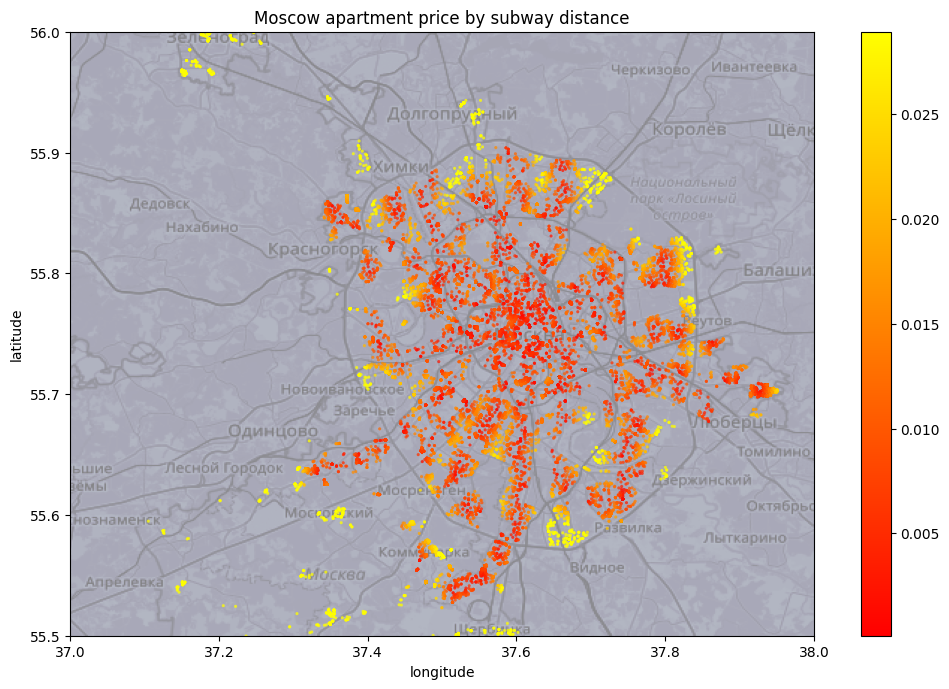

In [21]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='subway_distance', title='Moscow apartment price by subway distance'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/raw_data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(data)

In [22]:
# Cluster data points geographically
clusterer = KMeans(n_clusters=10, n_init=10)
clusterer.fit(data[["latitude", "longitude"]])

data["cluster"] = clusterer.predict(data[["latitude", "longitude"]])
data_test["cluster"] = clusterer.predict(data_test[["latitude", "longitude"]])

(<AxesSubplot:title={'center':'Moscow apartment price by cluster'}, xlabel='longitude', ylabel='latitude'>,
 None)

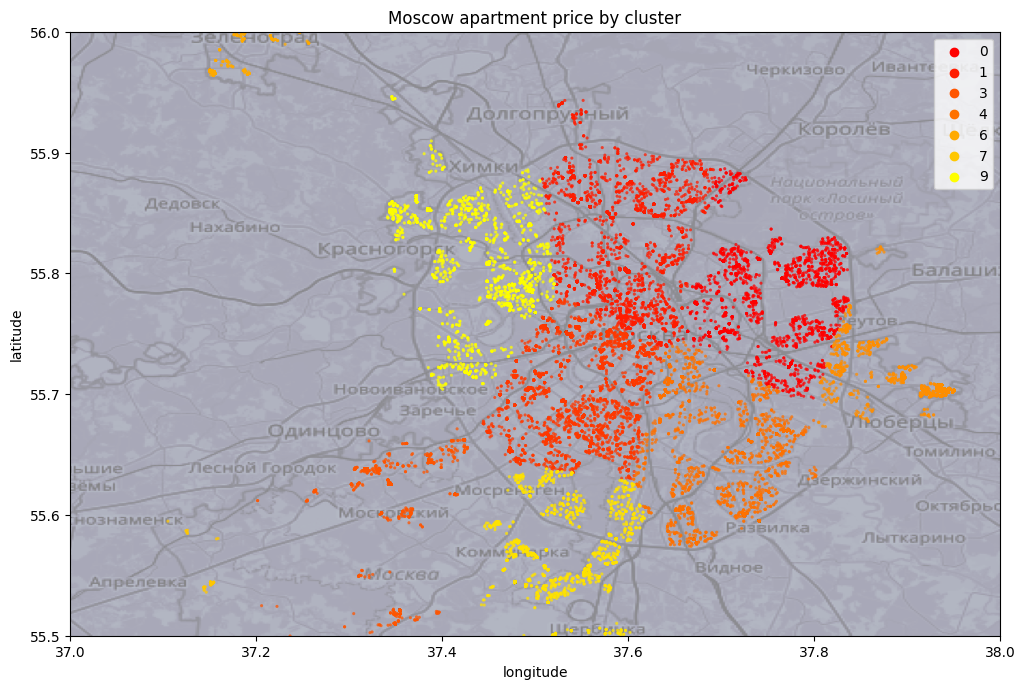

In [23]:
plot_map(data, column="cluster", title="Moscow apartment price by cluster")

In [24]:
# layout has lots of missing values - drop the column from data and data_test
# address and street have string values, so we lose them as well
data.drop(["layout", "address", "street"], axis=1, inplace=True)
data_test.drop(["layout", "address", "street"], axis=1, inplace=True)

In [25]:
data.reset_index(inplace=True)

# Train/test split

In [26]:
data_train, data_valid = train_test_split(
    data.drop(["price_bin"], axis=1),
    test_size = 0.3,
    stratify = data["price_bin"],
)

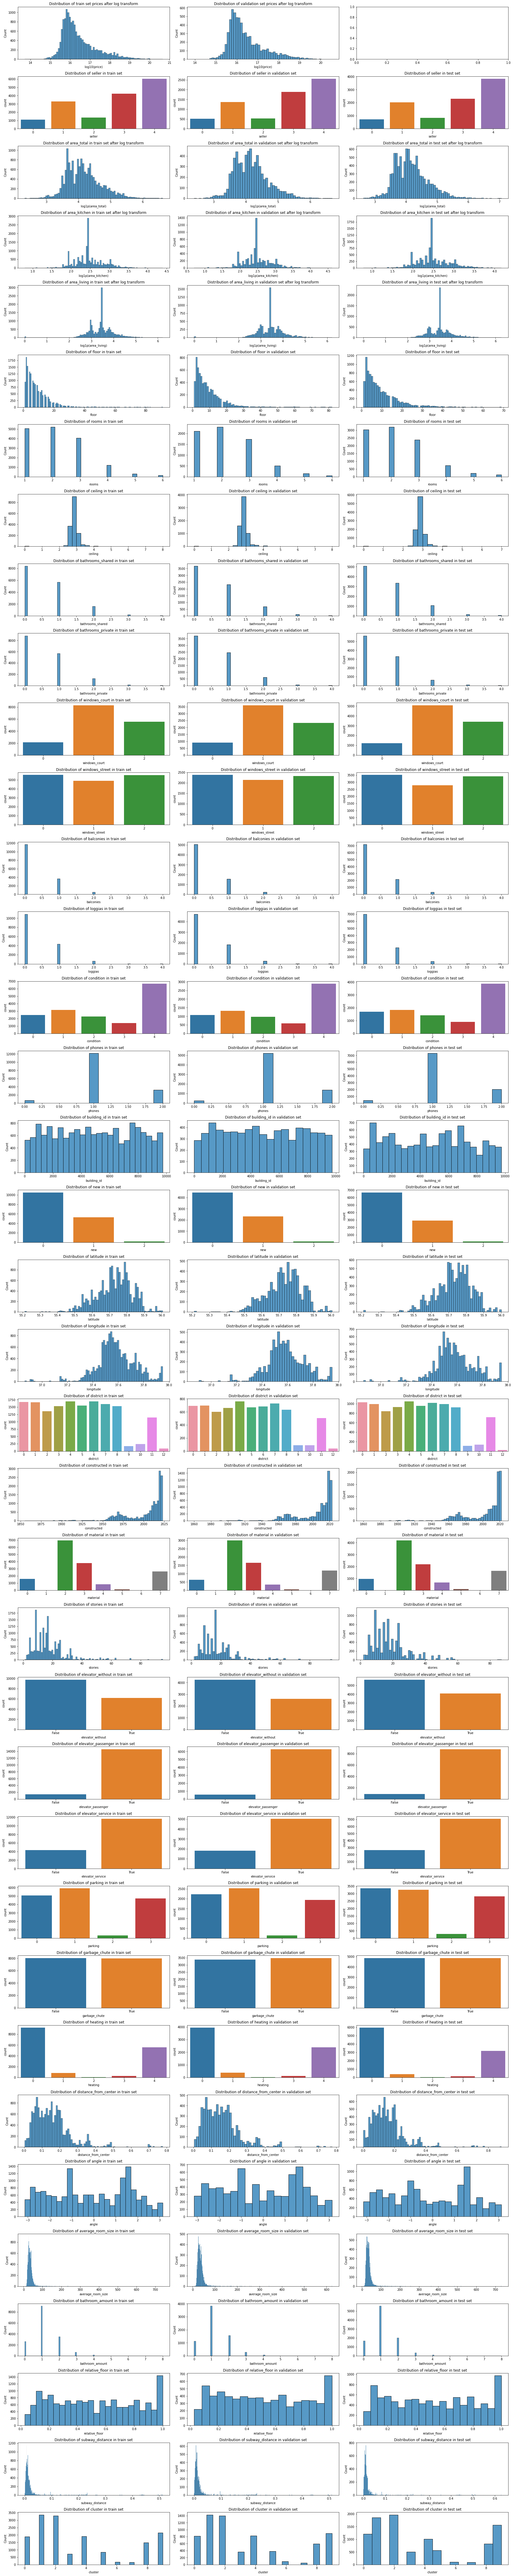

In [27]:
fig, ax = plt.subplots(figsize=(24, 120), ncols=3, nrows=data_train.shape[1] - 1, tight_layout={"pad": 1})
sns.histplot(np.log1p(data_train["price"]).rename('log10(price)'), ax=ax[0, 0])
ax[0, 0].set_title('Distribution of train set prices after log transform')
sns.histplot(np.log1p(data_valid["price"]).rename('log10(price)'), ax=ax[0, 1])
ax[0, 1].set_title('Distribution of validation set prices after log transform')
for i, column in enumerate(data_train.columns.drop(["price", "id"]), start=1):
    if column.startswith("area_"):
        sns.histplot(np.log1p(data_train[column]).rename(f"log1p({column})"), ax=ax[i, 0])
        sns.histplot(np.log1p(data_valid[column]).rename(f"log1p({column})"), ax=ax[i, 1])
        sns.histplot(np.log1p(data_test[column]).rename(f"log1p({column})"), ax=ax[i, 2])
        ax[i, 0].set_title(f'Distribution of {column} in train set after log transform')
        ax[i, 1].set_title(f'Distribution of {column} in validation set after log transform')
        ax[i, 2].set_title(f'Distribution of {column} in test set after log transform')
        continue
    if column == "ceiling":
        sns.histplot(data_train[column], ax=ax[i, 0], binwidth=0.25)
        sns.histplot(data_valid[column], ax=ax[i, 1], binwidth=0.25)
        sns.histplot(data_test[column], ax=ax[i, 2], binwidth=0.25)
    elif data_train[column].dtype in ("bool", "category"):
        sns.countplot(x=column, data=data_train, ax=ax[i, 0])
        sns.countplot(x=column, data=data_valid, ax=ax[i, 1])
        sns.countplot(x=column, data=data_test, ax=ax[i, 2])
    else:
        sns.histplot(data_train[column], ax=ax[i, 0])
        sns.histplot(data_valid[column], ax=ax[i, 1])
        sns.histplot(data_test[column], ax=ax[i, 2])
    ax[i, 0].set_title(f'Distribution of {column} in train set')
    ax[i, 1].set_title(f'Distribution of {column} in validation set')
    ax[i, 2].set_title(f'Distribution of {column} in test set')

In [37]:
data_train_no_id = data_train.drop("id", axis=1)
data_valid_no_id = data_valid.drop("id", axis=1)

In [38]:
data_train_no_id.to_csv("data/preprocessed/data_train.csv", index_label="id")
data_valid_no_id.to_csv("data/preprocessed/data_valid.csv", index_label="id")
data_test.to_csv("data/preprocessed/test.csv", index_label="id")

In [39]:
fig.set_facecolor("w")
fig.savefig("images/split-distribution.png")